# Parameter Sampler + Void Generator Test

Test the full pipeline: sample parameters from real/close/far distributions and generate void images.

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Add src to path
sys.path.append(str(Path.cwd().parent))

from src.data_generation.parameter_sampler import ParameterSampler
from src.data_generation.void_generator import VoidGenerator

## Initialize Components

In [2]:
# Load config to get master seed
import yaml
config_path = Path("../configs/experiment_config.yaml")
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

BASE_SEED = config['random_seed']
print(f"Using master seed: {BASE_SEED}")

# Initialize sampler (loads from configs/experiment_config.yaml)
sampler = ParameterSampler()

# Initialize generator with base chip images
base_image_dir = Path("../data/base_chips")
generator = VoidGenerator(base_image_dir)

Using master seed: 42
Loaded 5 base chip images


## Sample Parameters from Each Distribution

In [3]:
# Sample 3 parameter sets from each distribution (real, close, far)
# All seeds derived from master seed
real_params = sampler.sample_parameter_sets('real', n_sets=3, seed=BASE_SEED)
close_params = sampler.sample_parameter_sets('close', n_sets=3, seed=BASE_SEED + 100)
far_params = sampler.sample_parameter_sets('far', n_sets=3, seed=BASE_SEED + 200)

print("=== REAL Distribution ===")
for i, params in enumerate(real_params):
    print(f"\nParam Set {i+1}:")
    for key, value in params.items():
        print(f"  {key}: {value}")

print("\n=== CLOSE Distribution ===")
for i, params in enumerate(close_params):
    print(f"\nParam Set {i+1}:")
    for key, value in params.items():
        print(f"  {key}: {value}")

print("\n=== FAR Distribution ===")
for i, params in enumerate(far_params):
    print(f"\nParam Set {i+1}:")
    for key, value in params.items():
        print(f"  {key}: {value}")

=== REAL Distribution ===

Param Set 1:
  void_shape: ellipse
  void_count: 5
  base_size: 15.0
  brightness_factor: 0.63
  size_std: 8.0
  position_spread: 0.41

Param Set 2:
  void_shape: circle
  void_count: 6
  base_size: 15.0
  brightness_factor: 0.41
  size_std: 3.6
  position_spread: 0.42

Param Set 3:
  void_shape: ellipse
  void_count: 7
  base_size: 15.0
  brightness_factor: 0.53
  size_std: 2.7
  position_spread: 0.41

=== CLOSE Distribution ===

Param Set 1:
  void_shape: irregular
  void_count: 10
  base_size: 15.0
  brightness_factor: 0.51
  size_std: 8.0
  position_spread: 0.6

Param Set 2:
  void_shape: ellipse
  void_count: 9
  base_size: 15.0
  brightness_factor: 0.5
  size_std: 6.9
  position_spread: 0.62

Param Set 3:
  void_shape: circle
  void_count: 10
  base_size: 9.7
  brightness_factor: 0.58
  size_std: 8.0
  position_spread: 0.63

=== FAR Distribution ===

Param Set 1:
  void_shape: circle
  void_count: 10
  base_size: 7.6
  brightness_factor: 0.3
  size_std:

## Generate Images from Sampled Parameters

Generate one image per parameter set (3 real + 3 close + 3 far = 9 images)

In [4]:
# Combine all parameter sets
all_params = [
    ('real', real_params[0]),
    ('real', real_params[1]),
    ('real', real_params[2]),
    ('close', close_params[0]),
    ('close', close_params[1]),
    ('close', close_params[2]),
    ('far', far_params[0]),
    ('far', far_params[1]),
    ('far', far_params[2]),
]

# Generate images - use derived seeds from master
images = []
metadata_list = []

for i, (dist_type, params) in enumerate(all_params):
    # Seed derived from BASE_SEED + distribution offset + index
    seed = BASE_SEED + (0 if dist_type == 'real' else 100 if dist_type == 'close' else 200) + i
    img, metadata = generator.generate_single(params, seed=seed)
    images.append((dist_type, img))
    metadata_list.append(metadata)

print(f"Generated {len(images)} images")

Generated 9 images


## Visualize: 3x3 Grid (Real, Close, Far)

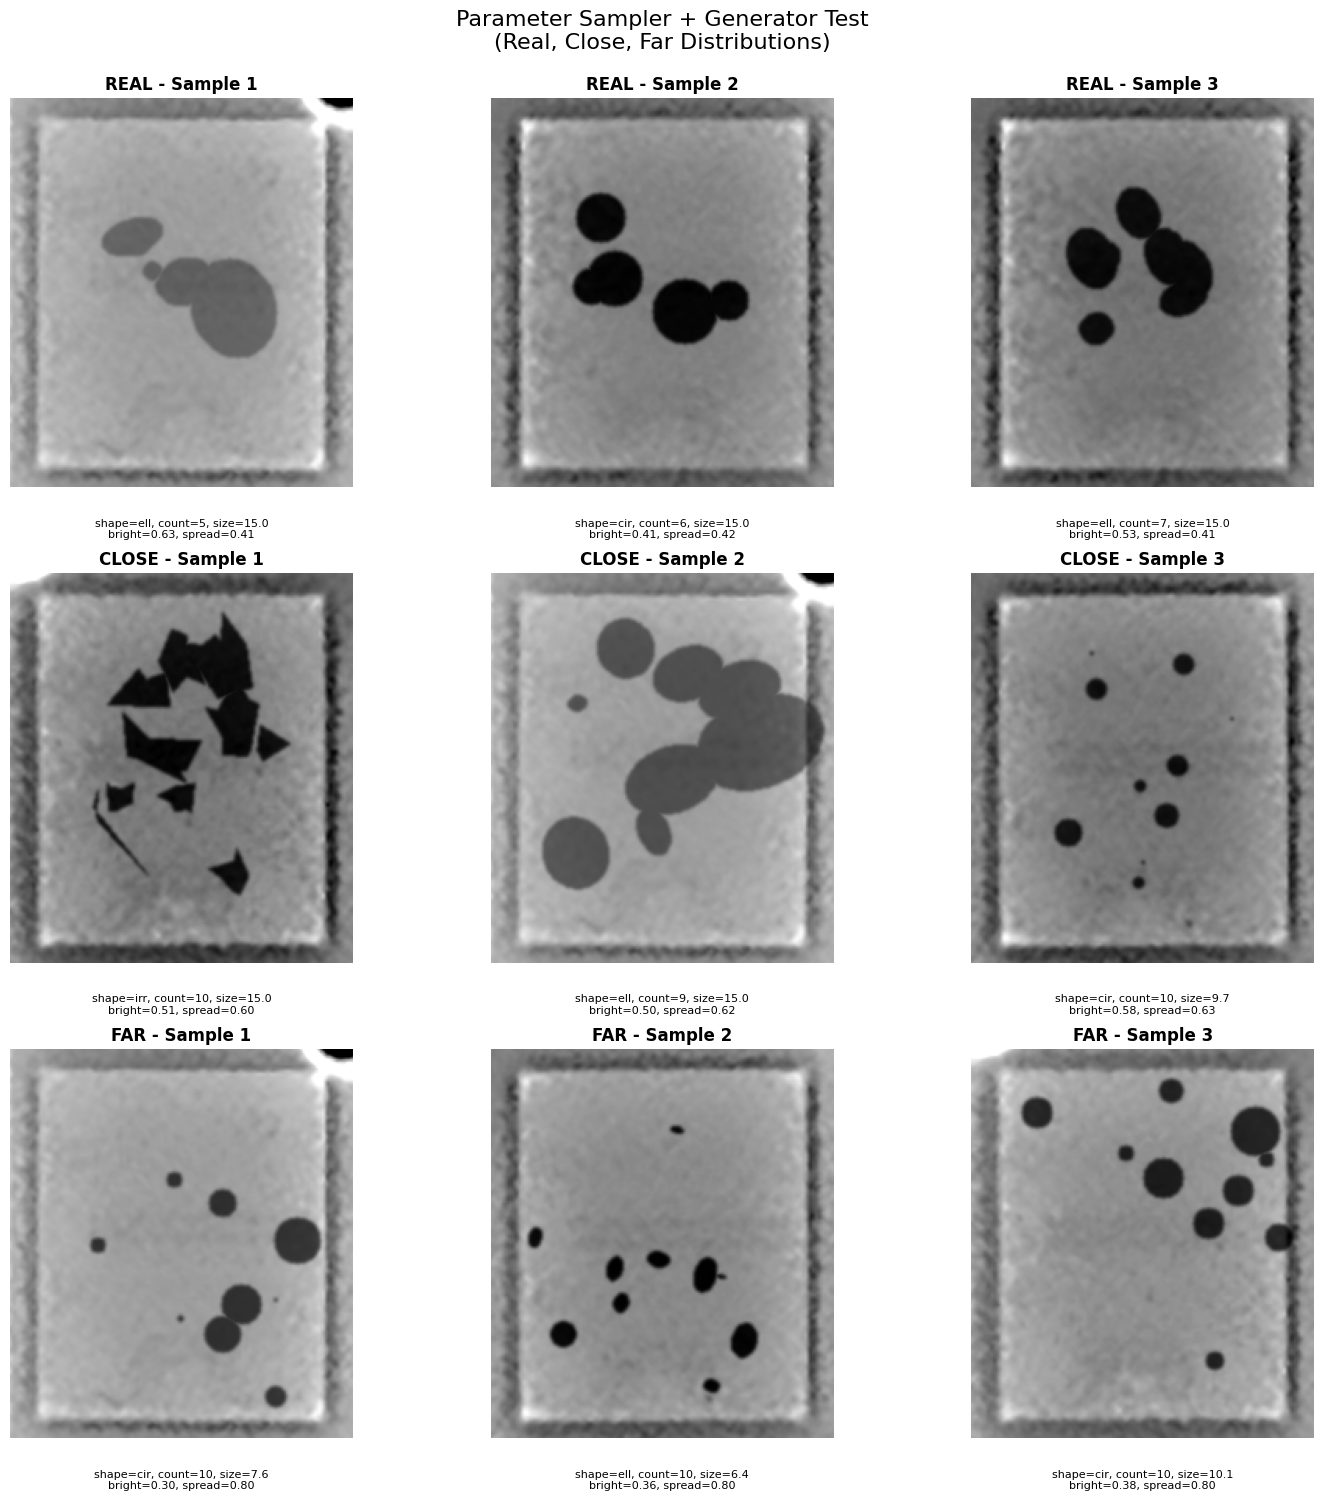

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Parameter Sampler + Generator Test\n(Real, Close, Far Distributions)', fontsize=16, y=0.995)

for idx, (ax, (dist_type, img)) in enumerate(zip(axes.flat, images)):
    ax.imshow(img, cmap='gray')
    
    # Get row and column for labeling
    row = idx // 3
    col = idx % 3
    
    # Title with distribution type and sample number
    dist_labels = {0: 'REAL', 1: 'CLOSE', 2: 'FAR'}
    title = f"{dist_labels[row]} - Sample {col+1}"
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    # Add parameter summary
    params = metadata_list[idx]['params']
    info_text = f"shape={params['void_shape'][:3]}, count={params['void_count']}, size={params['base_size']:.1f}\nbright={params['brightness_factor']:.2f}, spread={params['position_spread']:.2f}"
    ax.text(0.5, -0.08, info_text, transform=ax.transAxes, 
            fontsize=8, ha='center', va='top')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Test Replications

Generate multiple replications of the same parameter set (with different seeds)

Testing replications with parameters:
  void_shape: ellipse
  void_count: 5
  base_size: 15.0
  brightness_factor: 0.63
  size_std: 8.0
  position_spread: 0.41


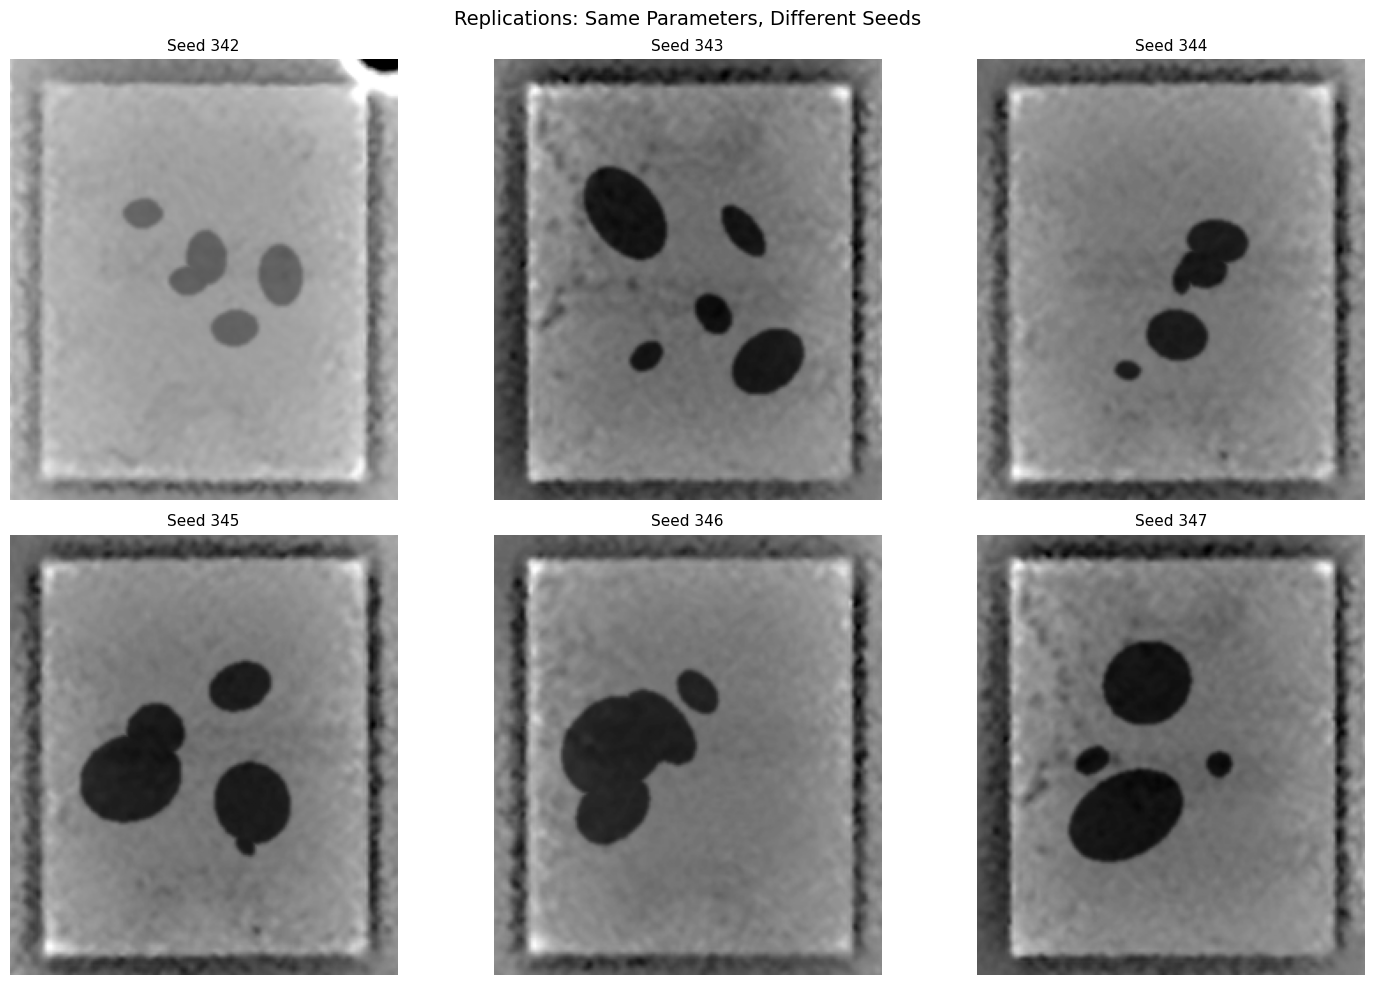

In [6]:
# Use one parameter set from 'real' distribution
test_params = real_params[0]

print("Testing replications with parameters:")
for key, value in test_params.items():
    print(f"  {key}: {value}")

# Generate 6 replications with different seeds derived from master
replication_images = []
for i in range(6):
    seed = BASE_SEED + 300 + i  # Offset 300 for replication tests
    img, _ = generator.generate_single(test_params, seed=seed)
    replication_images.append(img)

# Display replications
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Replications: Same Parameters, Different Seeds', fontsize=14)

for idx, (ax, img) in enumerate(zip(axes.flat, replication_images)):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Seed {BASE_SEED + 300 + idx}', fontsize=11)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Test Batch Generation (As Per Experiment Config)

Simulate iteration 0 dataset configuration:
- Real: 5 param sets × 3 replications = 15 images
- Close: 8 param sets × 3 replications = 24 images  
- Far: 8 param sets × 3 replications = 24 images

In [7]:
# Sample according to experiment config
# All seeds derived from BASE_SEED: real=base, close=base+100, far=base+200
real_batch_params = sampler.sample_parameter_sets('real', n_sets=5, seed=BASE_SEED)
close_batch_params = sampler.sample_parameter_sets('close', n_sets=8, seed=BASE_SEED + 100)
far_batch_params = sampler.sample_parameter_sets('far', n_sets=8, seed=BASE_SEED + 200)

# Generate images with replications using different seed offsets for each distribution
# Offsets: real=0, close=1000, far=2000
real_images, real_metadata = generator.generate_batch(real_batch_params, replications=3, seed_offset=0)
close_images, close_metadata = generator.generate_batch(close_batch_params, replications=3, seed_offset=1000)
far_images, far_metadata = generator.generate_batch(far_batch_params, replications=3, seed_offset=2000)

print(f"Master seed: {BASE_SEED}")
print(f"\nReal distribution: {len(real_images)} images ({len(real_batch_params)} param sets × 3 replications)")
print(f"  Sampler seed: {BASE_SEED}, Generator offset: 0")
print(f"\nClose distribution: {len(close_images)} images ({len(close_batch_params)} param sets × 3 replications)")
print(f"  Sampler seed: {BASE_SEED + 100}, Generator offset: 1000")
print(f"\nFar distribution: {len(far_images)} images ({len(far_batch_params)} param sets × 3 replications)")
print(f"  Sampler seed: {BASE_SEED + 200}, Generator offset: 2000")
print(f"\nTotal: {len(real_images) + len(close_images) + len(far_images)} images")

Master seed: 42

Real distribution: 15 images (5 param sets × 3 replications)
  Sampler seed: 42, Generator offset: 0

Close distribution: 24 images (8 param sets × 3 replications)
  Sampler seed: 142, Generator offset: 1000

Far distribution: 24 images (8 param sets × 3 replications)
  Sampler seed: 242, Generator offset: 2000

Total: 63 images


## Sample Metadata Inspection

In [8]:
import json

print("Sample metadata from real distribution:")
print(json.dumps(real_metadata[0], indent=2))

Sample metadata from real distribution:
{
  "params": {
    "void_shape": "ellipse",
    "void_count": 5,
    "base_size": 15.0,
    "brightness_factor": 0.63,
    "size_std": 8.0,
    "position_spread": 0.41
  },
  "seed": 0,
  "base_image_id": "NoVoids_53438_0023_result.png",
  "base_image_idx": 4,
  "uncontrolled_params": {
    "rotation": 213.4240625610066,
    "edge_blur": 2
  },
  "voids": [
    {
      "void_id": 0,
      "x": 141.3221068383281,
      "y": 137.66527892056217,
      "size": 15.947971685899269,
      "shape": "ellipse"
    },
    {
      "void_id": 1,
      "x": 91.7376215103114,
      "y": 79.56308017503792,
      "size": 15.911742359767258,
      "shape": "ellipse"
    },
    {
      "void_id": 2,
      "x": 108.19394094823016,
      "y": 114.01044160033504,
      "size": 25.92373743609937,
      "shape": "ellipse"
    },
    {
      "void_id": 3,
      "x": 95.3331336696376,
      "y": 140.1876168852477,
      "size": 14.2184342262446,
      "shape": "ellipse"


## Visualize Sample from Each Distribution Batch

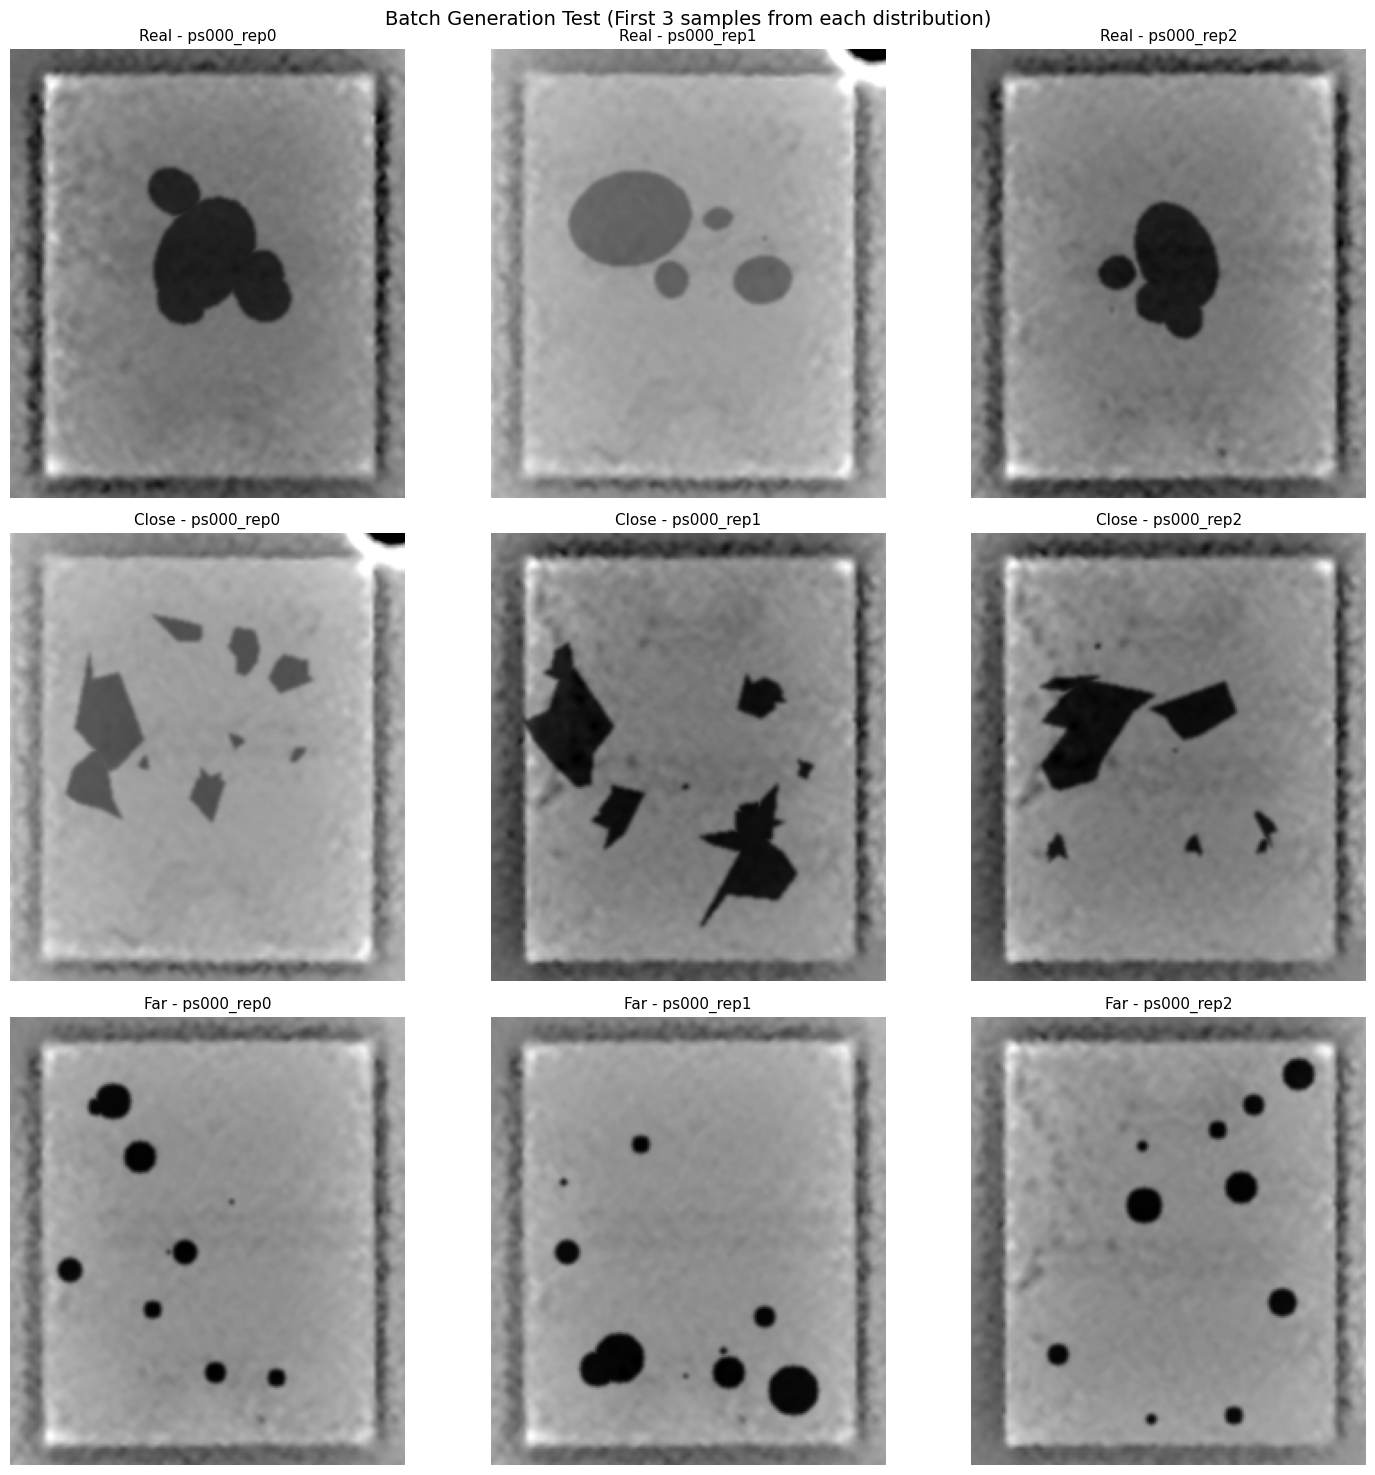

In [9]:
# Show first 3 samples from each distribution
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Batch Generation Test (First 3 samples from each distribution)', fontsize=14)

sample_images = [
    ('Real', real_images[0]),
    ('Real', real_images[1]),
    ('Real', real_images[2]),
    ('Close', close_images[0]),
    ('Close', close_images[1]),
    ('Close', close_images[2]),
    ('Far', far_images[0]),
    ('Far', far_images[1]),
    ('Far', far_images[2]),
]

sample_metadata = [
    real_metadata[0], real_metadata[1], real_metadata[2],
    close_metadata[0], close_metadata[1], close_metadata[2],
    far_metadata[0], far_metadata[1], far_metadata[2],
]

for idx, (ax, (label, img), meta) in enumerate(zip(axes.flat, sample_images, sample_metadata)):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{label} - {meta['sample_id']}", fontsize=11)
    ax.axis('off')

plt.tight_layout()
plt.show()